# EDA & NLP

### This notebook shows the 4th part of exploratory data analysis:

3. Article content ananlysis <br>
    a. Analysis on article headlines<br>
    b. Analysis on articles types<br>
    c. Count vector<br>
    d. TF-IDF transformation<br>

In [681]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer 

In [683]:
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download("maxent_treebank_pos_tagger")
# nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jiaping/nltk_data...


True

In [560]:
%store -r train_df
%store -r valid_df
%store -r test_df
%store -r interval_lists

In [604]:
# define some functions

# data cleaning on the leadines
def clean_headline(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

# data cleaning on category
def clean_category(text):
#     text = re.sub(r'&', "", text) # remove "&"
#     text = re.sub(r'-', "", text) # remove "-"
#     text = re.sub(r"'", " ", text) # remove '
#     text = re.sub(r' ', "", text) # remove space
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text) # remove all the punctuations with space
    return text

# remove stopwords
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words 

# lemmatize the each list
def lem_word(x):
    return [lemmatize(w) for w in x]

# lemmatize the word in the lists
lem = WordNetLemmatizer()
def lemmatize(w):
    # Get the single character pos constant from pos_tag like this:
    pos_label = (pos_tag(word_tokenize(w))[0][1][0]).lower()
    w = lem.lemmatize(w, pos = 'a')
    w = lem.lemmatize(w, pos = 'n')
    w = lem.lemmatize(w, pos = 'v')
    w = lem.lemmatize(w, pos = 's')
    try: 
        if pos_label in ['r']:  # For adverbs it's a bit different
            w = wordnet.synset(w+'.r.1').lemmas()[0].pertainyms()[0].name()
    except:
        pass
    return w

# combine a list of words into a atring
def combine_text(list_of_text):
    '''Takes a list of text and combines them into one large chunk of text.'''
    combined_text = ' '.join(list_of_text)
    return combined_text

# add sentimental component to each article
sid = SentimentIntensityAnalyzer()
def sentiment_tag(train_articles_df): 
    train_articles_df['h_score'] = train_articles_df['headline'].apply(lambda x: sid.polarity_scores(x))
    train_articles_df['h_score'] = train_articles_df['h_score'].apply(lambda score_dict: score_dict['compound'])
    train_articles_df['h_compound'] = train_articles_df['h_score'].apply(lambda c: 'positive' if c >= 0 else 'negative')
    return train_articles_df

In [686]:
train_articles_df = train_df.drop_duplicates(subset='contentID', keep='first', inplace=False)[['contentID', 'headline', 'categories','releaseDateTime']].reset_index(drop=True)
val_articles_df = valid_df.drop_duplicates(subset='contentID', keep='first', inplace=False)[['contentID', 'headline', 'categories','releaseDateTime']].reset_index(drop=True)

In [687]:
train_articles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8529 entries, 0 to 8528
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   contentID        8529 non-null   object
 1   headline         8529 non-null   object
 2   categories       8523 non-null   object
 3   releaseDateTime  8529 non-null   object
dtypes: object(4)
memory usage: 266.7+ KB


There are some missing categories for some articles.

In [688]:
val_articles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1853 entries, 0 to 1852
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   contentID        1853 non-null   object
 1   headline         1853 non-null   object
 2   categories       1853 non-null   object
 3   releaseDateTime  0 non-null      object
dtypes: object(4)
memory usage: 58.0+ KB


### a. Data cleaning, processing and basic EDA on articles healdines and categories

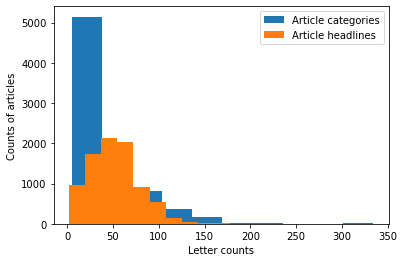

In [564]:
category_length = train_articles_df['categories'].str.len() 
plt.hist(category_length, label="Article categories") 
headline_length = train_articles_df['headline'].str.len() 
plt.hist(headline_length, label="Article headlines") 
plt.xlabel('Letter counts')
plt.ylabel('Counts of articles')
plt.legend() 
plt.show()

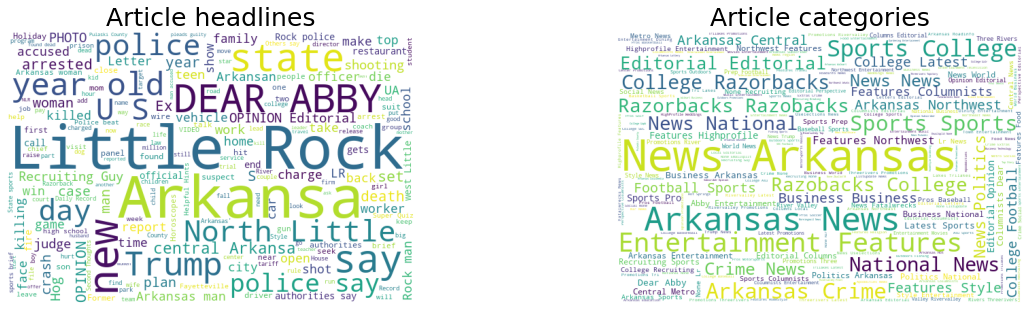

In [585]:
# visualize the distribution of keywords in article headlines and types

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[20, 5])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(train_articles_df['headline']))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Article headlines',fontsize=25);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(train_articles_df.dropna()['categories']))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Article categories',fontsize=25);

#### Basic cleaning on the headline and categories

In [689]:
train_articles_df = train_articles_df.dropna().reset_index(drop=True)
val_articles_df = val_articles_df.dropna().reset_index(drop=True)
train_articles_df['headline'] = train_articles_df['headline'].apply(lambda x: clean_headline(x))
val_articles_df['headline'] = val_articles_df['headline'].apply(lambda x: clean_headline(x))
train_articles_df['headline'].head()

0         arrested state legislator urged to quit post
1    suspect arrested in fatal shooting in pulaski ...
2    police officer fatally shoots self at central ...
3    motorcyclist killed in headon crash in little ...
4    the recruiting guy early offer gets highly rec...
Name: headline, dtype: object

In [690]:
# remove articles with missing categories
train_articles_df['categories'] = train_articles_df['categories'].apply(lambda x: clean_category(x))
val_articles_df['categories'] = val_articles_df['categories'].apply(lambda x: clean_category(x))
train_articles_df['categories'].head()

0               News Arkansas   News Politics Arkansas
1                                  News Arkansas Crime
2                                        News Arkansas
3                  News Arkansas   News Arkansas Crime
4    None Recruiting   Sports College Razorbacks Ra...
Name: categories, dtype: object

#### Tokenize all the headlines

In [691]:
# tokenize all the categories
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
train_articles_df['headline'] = train_articles_df['headline'].apply(lambda x:tokenizer.tokenize(x))
val_articles_df['headline'] = val_articles_df['headline'].apply(lambda x:tokenizer.tokenize(x))
train_articles_df['headline'].head()

0    [arrested, state, legislator, urged, to, quit,...
1    [suspect, arrested, in, fatal, shooting, in, p...
2    [police, officer, fatally, shoots, self, at, c...
3    [motorcyclist, killed, in, headon, crash, in, ...
4    [the, recruiting, guy, early, offer, gets, hig...
Name: headline, dtype: object

#### Remove stopwords in headlines

In [692]:
train_articles_df['headline'] = train_articles_df['headline'].apply(lambda x : remove_stopwords(x))
val_articles_df['headline'] = val_articles_df['headline'].apply(lambda x : remove_stopwords(x))
train_articles_df['headline'].head()

0     [arrested, state, legislator, urged, quit, post]
1    [suspect, arrested, fatal, shooting, pulaski, ...
2    [police, officer, fatally, shoots, self, centr...
3    [motorcyclist, killed, headon, crash, little, ...
4    [recruiting, guy, early, offer, gets, highly, ...
Name: headline, dtype: object

#### Word lemmatization for headline column

In [693]:
train_articles_df['headline'] = train_articles_df['headline'].apply(lem_word)
val_articles_df['headline'] = val_articles_df['headline'].apply(lem_word)
train_articles_df['headline'].head()

0        [arrest, state, legislator, urge, quit, post]
1     [suspect, arrest, fatal, shoot, pulaski, county]
2    [police, officer, fatal, shoot, self, central,...
3    [motorcyclist, kill, headon, crash, little, ro...
4    [recruit, guy, early, offer, get, high, recrui...
Name: headline, dtype: object

#### Combined the text together in the headline column

In [694]:
train_articles_df['headline'] = train_articles_df['headline'].apply(lambda x : combine_text(x))
val_articles_df['headline'] = val_articles_df['headline'].apply(lambda x : combine_text(x))
train_articles_df.head()

,contentID,headline,categories,releaseDateTime
0,www.arkansasonline.com/news/2018/jun/30/arrest...,arrest state legislator urge quit post,News Arkansas News Politics Arkansas,2018-07-01
1,www.arkansasonline.com/news/2018/jun/30/suspec...,suspect arrest fatal shoot pulaski county,News Arkansas Crime,2018-07-01
2,www.arkansasonline.com/news/2018/jun/30/police...,police officer fatal shoot self central arkans...,News Arkansas,2018-07-01
3,www.arkansasonline.com/news/2018/jun/30/motorc...,motorcyclist kill headon crash little rock suv...,News Arkansas News Arkansas Crime,2018-07-01
4,www.arkansasonline.com/news/2018/jun/30/early-...,recruit guy early offer get high recruit wr ca...,None Recruiting Sports College Razorbacks Ra...,2018-07-01


In [507]:
# # capitalize the first letter only for all the category tokens in the lists
# def capOnly(categories):
#     '''Takes a list of strings and only capitalize the first letter of each string only.'''
#     new_list = [(category[:1].upper() + category[1:]) for category in categories]
#     return new_list 

# train_articles_df['categories'] = train_articles_df['categories'].apply(lambda x: capOnly(x))
# # val_articles_df['categories'] = val_articles_df['categories'].apply(lambda x: capOnly(x))
# train_articles_df['categories'].head()

In [510]:
# # combine the tokens together
# def combine_text(list_of_text):
#     '''Takes a list of text and combines them into one large chunk of text.'''
#     combined_text = ' '.join(list_of_text)
#     return combined_text

# train_articles_df['categories'] = train_articles_df['categories'].apply(lambda x: combine_text(x))
# # val_articles_df['categories'] = val_articles_df['categories'].apply(lambda x: combine_text(x))
# train_articles_df['categories']

0       News Arkansas News Politics Arkansas LawGovern...
1                                     News Arkansas Crime
2       News Arkansas LawGovernment PublicSafety Crime...
3                       News Arkansas News Arkansas Crime
4       None Recruiting Sports College Razorbacks Razo...
                              ...                        
8524    News World Health HealthConditions InfectiousD...
8525                                           News World
8526                         Entertainment Features Style
8527                         Entertainment Features Style
8528    Sports College Razorbacks RazobacksCollegeFoot...
Name: categories, Length: 8529, dtype: object

In [714]:
sentiment_tag(train_articles_df)
train_articles_df.head()

,contentID,headline,categories,releaseDateTime,h_score,h_compound
0,www.arkansasonline.com/news/2018/jun/30/arrest...,arrest state legislator urge quit post,News Arkansas News Politics Arkansas,2018-07-01,-0.3400,negative
1,www.arkansasonline.com/news/2018/jun/30/suspec...,suspect arrest fatal shoot pulaski county,News Arkansas Crime,2018-07-01,-0.8591,negative
2,www.arkansasonline.com/news/2018/jun/30/police...,police officer fatal shoot self central arkans...,News Arkansas,2018-07-01,-0.7096,negative
3,www.arkansasonline.com/news/2018/jun/30/motorc...,motorcyclist kill headon crash little rock suv...,News Arkansas News Arkansas Crime,2018-07-01,-0.8126,negative
4,www.arkansasonline.com/news/2018/jun/30/early-...,recruit guy early offer get high recruit wr ca...,None Recruiting Sports College Razorbacks Ra...,2018-07-01,0.4588,positive


In [711]:
Counter(train_articles_df['h_compound'])

Counter({'negative': 2639, 'positive': 5884})

About 2/3 of articles in the training set are positive

### b. Count-vector transformation

In [715]:
count_vectorizer = CountVectorizer()

In [526]:
train_vector = count_vectorizer.fit_transform(train_articles_df['categories'])
val_vector = count_vectorizer.transform(val_articles_df['categories'])
print(train_vector[0].todense())
len(count_vectorizer.get_feature_names()) # 423

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


423

In [528]:
train_feature_df = pd.DataFrame(train_vector.toarray())
train_feature_df.columns = count_vectorizer.get_feature_names()
train_feature_df

,2010election,accountingauditing,actingtheater,activestyle,activities,acxiom,adgbreaking,adghighschool,adgpolitics,adgsports,...,world,worldbusiness,wrestling,zballot18,zcongress18,zeditorial2018,zgovernor18,zoosaquariumspreserves,zstatehouse18,zsupremecourt
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8524,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
8525,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
8526,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8527,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [550]:
train_category_df = pd.DataFrame(train_feature_df.astype(bool).sum(axis=1))
train_category_df.columns = ['CategoryCounts']
train_category_df['CategoryCounts'].describe()

count    8529.00000
mean        3.69164
std         1.88777
min         0.00000
25%         2.00000
50%         3.00000
75%         5.00000
max        15.00000
Name: CategoryCounts, dtype: float64

Text(0.5, 0, 'Number of categories')

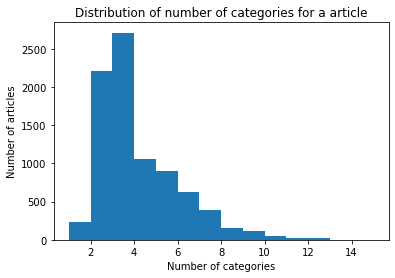

In [553]:
plt.hist(train_category_df['CategoryCounts'], bins = range(1,16))
plt.title('Distribution of number of categories for a article')
plt.ylabel('Number of articles')
plt.xlabel('Number of categories')

It can be noticed that most articles are included in 2-3 categories.

In [529]:
cols = train_feature_df.columns
bt = train_feature_df.apply(lambda x: x > 0)
bt.apply(lambda x: list(cols[x.values]), axis=1)

0        [arkansas, lawgovernment, legal, news, politics]
1                                 [arkansas, crime, news]
2       [arkansas, crimejustice, lawgovernment, news, ...
3                                 [arkansas, crime, news]
4       [college, none, razobackscollegelatest, razoba...
                              ...                        
8524    [health, healthconditions, infectiousdiseases,...
8525                                        [news, world]
8526                     [entertainment, features, style]
8527                     [entertainment, features, style]
8528    [college, razobackscollegefootball, razobacksc...
Length: 8529, dtype: object

In [530]:
# The numbe of article with category
train_df_df = pd.DataFrame(train_feature_df.astype(bool).sum(axis=0))
train_df_df.columns = ['df']
train_df_df = train_df_df.sort_values('df', ascending = False)
train_df_df['percent'] = train_df_df['df']/len(train_feature_df)
train_df_df 

,df,percent
news,4649,0.545081
arkansas,3758,0.440614
entertainment,1440,0.168836
sports,1411,0.165436
features,1200,0.140696
...,...,...
politicalscience,1,0.000117
popmusic,1,0.000117
corrections,1,0.000117
concerts,1,0.000117


Text(0.5, 0, 'Category')

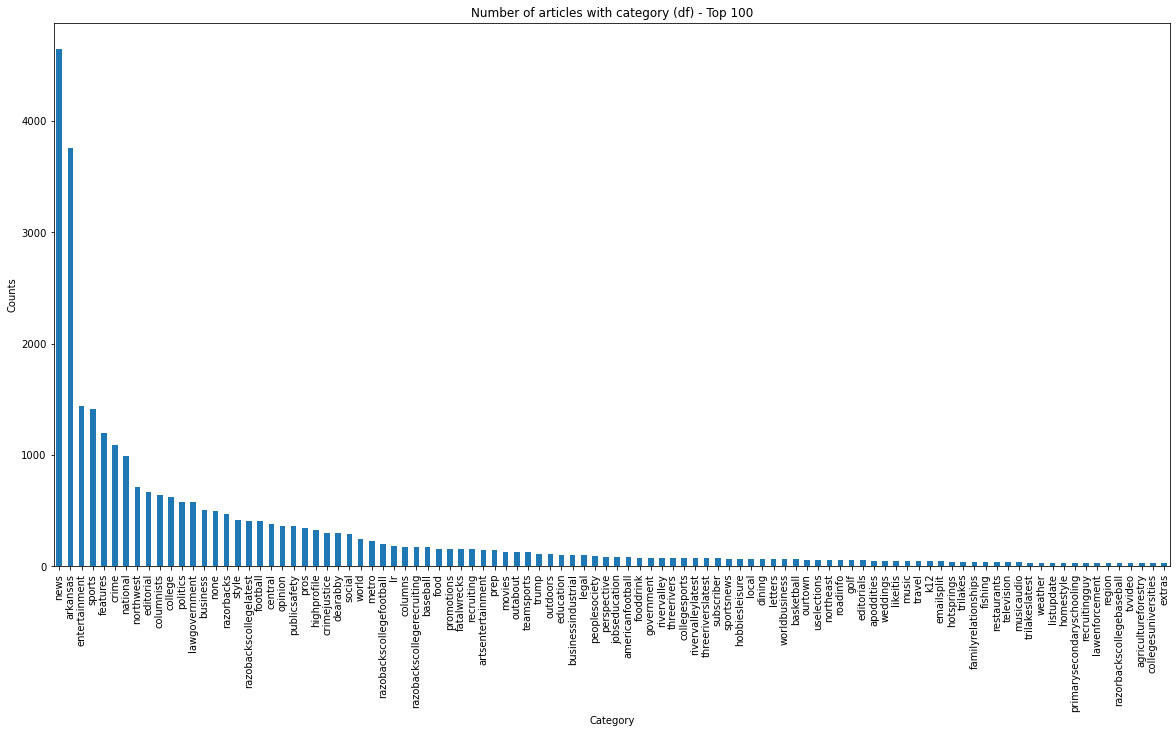

In [531]:
train_df_df['df'].iloc[0:100].plot(kind = 'bar', figsize = (20,10))
plt.title('Number of articles with category (df) - Top 100')
plt.ylabel('Counts')
plt.xlabel('Category')

It is easy to know that about half of the articles are included in the categories of "News" and "Akansas". Optimization could be made with respect to the filtration of categories.

In [533]:
print(f"There are {len(train_df_df[train_df_df['df'] == 1])} categories with df equal to 1")
print(f"There are {len(train_df_df[train_df_df['df'] == 2])} categories with df equal to 2")
print(f"There are {len(train_df_df[train_df_df['df'] == 3])} categories with df equal to 3")

There are 115 categories with df equal to 1
There are 44 categories with df equal to 2
There are 31 categories with df equal to 3


In [534]:
train_category_counts = pd.DataFrame(train_feature_df.sum(axis = 0, skipna = True))
train_category_counts.columns = ['Counts']
train_category_counts.sort_values('Counts', ascending = False)

,Counts
news,8912
arkansas,5970
sports,3708
entertainment,2115
features,1965
...,...
concerts,1
corrections,1
razorbackssec,1
razobackscollegesoccer,1


Text(0.5, 0, 'Category')

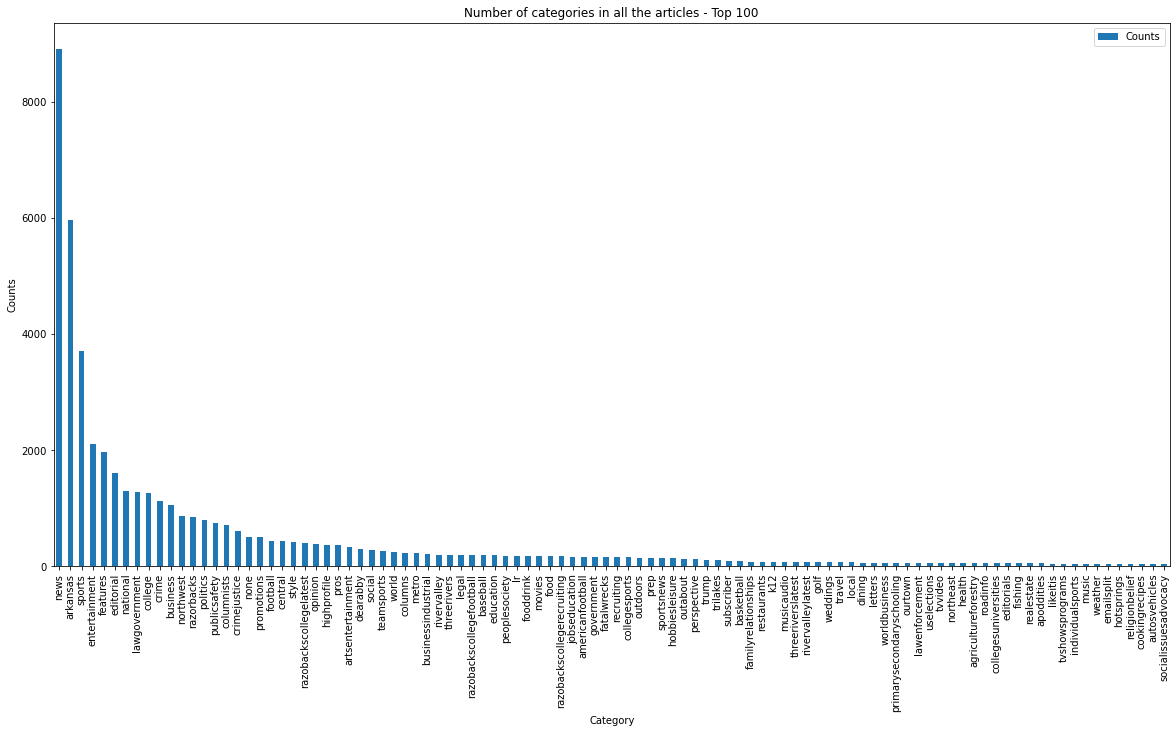

In [535]:
train_category_counts.sort_values('Counts', ascending = False).iloc[0:100].plot(kind = 'bar', figsize = (20,10))
plt.title('Number of categories in all the articles - Top 100')
plt.ylabel('Counts')
plt.xlabel('Category')

In [536]:
keywords_counts.sort_values('Counts').head(20)

,Counts
2010Election,1
BestoftheBest,1
Tennessee,1
Southeast,1
SimmonsFirstNational,1
Salineco,1
Running,1
Root,1
RestaurantReview,1
RazorbacksSec,1


### c. TF-IDF transformation

In [537]:
# min_df = mi, max_df = ma, optimize the parameters
tfidf = TfidfVectorizer() # min_df = 2, max_df = 0.4 norm = 'l2'
train_tfidf = tfidf.fit_transform(train_articles_df['categories'])
# val_tfidf = tfidf.transform(val_articles_df['categories'])
train_tfidf.todense() # 423

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

The features and corresponding weights in each articles are included in the train_tfidf matrix.

In [556]:
train_tfidf_df = pd.DataFrame(train_tfidf.toarray())
train_tfidf_df.columns = tfidf.get_feature_names()
# train_tfidf_df.to_csv('../data/cleaned/trainTFIDF.csv')

In [548]:
train_tfidf.todense().shape

(8529, 423)

In [541]:
tfidf.get_feature_names()[0:10]

['2010election',
 'accountingauditing',
 'actingtheater',
 'activestyle',
 'activities',
 'acxiom',
 'adgbreaking',
 'adghighschool',
 'adgpolitics',
 'adgsports']

In [540]:
train_tfidf[0].todense()

matrix([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.19478544,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0